## Mass Balance Gradient from Regional 

In [1]:
import geoutils as gu
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xdem
import xdem.volume

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline

In [2]:
ddem = xdem.DEM(r"D:/BICdata/BICDEMLcoreg_ddempostExpended.tif")
print("dDEM Coordinate Reference: " + str(ddem.crs))
print("Nodata vale: " + str(ddem.nodata))

dem_2021 = xdem.DEM(r"C:\Users\WilsonSIRL5-MCY-E113\Desktop\DEMdifferen\BIC.tif")
print("Reference Coordinate Reference: " + str(dem_2021.crs))
print("Nodata vale: " + str(dem_2021.nodata))

glacier_outlines = gu.Vector(r"C:\Users\WilsonSIRL5-MCY-E113\Documents\SNP ML\Outline\glacieroutline.shp")
#glacier_outlines = gu.Vector(r"D:/BICdata/OUTLINE.shp")
print("Outline CRS: " + str(glacier_outlines.crs))

#Masking the DEMs
mask = glacier_outlines.create_mask(ddem)
#Reprojecting the DEMs
reference_dem = dem_2021.reproject(ddem, silent=True, resampling='bilinear')

dDEM Coordinate Reference: EPSG:32617
Nodata vale: nan
Reference Coordinate Reference: EPSG:4326
Nodata vale: 3.3999999521443642e+38
Outline CRS: EPSG:32617


In [3]:
mask = glacier_outlines.create_mask(ddem)

no_data_value = ddem.nodata  # Replace with your DEM's no-data value if it's not NaN.
# Assuming ddem.data is a numpy array of DEM values. Remove the no-data values.
valid_dem_mask = ddem.data != no_data_value

# Update the glacier_pixels to consider only pixels that also have valid DEM values
glacier_pixels = np.count_nonzero(mask & valid_dem_mask)

# Update total_pixels to count only pixels with valid DEM values
total_pixels = np.count_nonzero(valid_dem_mask)

# Calculate the percentage of glacier coverage
glacier_coverage_percentage = (glacier_pixels / total_pixels) * 100

print(f"Number of glacier pixels: {glacier_pixels}")
print(f"Number of valid DEM pixels: {total_pixels}")
print(f"Glacier coverage percentage: {glacier_coverage_percentage:.2f}%")

Number of glacier pixels: 121673638
Number of valid DEM pixels: 632322325
Glacier coverage percentage: 19.24%


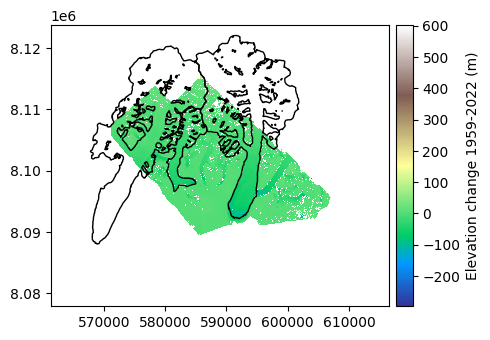

In [4]:
ddem.data = xdem.filters.distance_filter(ddem.data, radius=30, outlier_threshold=10)
#Filter out pixels whose value is distant more than a set threshold from the average value of all neighbor pixels within a given radius.

plt.figure(figsize=(5, 5))
ax = plt.subplot(111)
glacier_outlines.ds.plot(ax=ax, facecolor='none', edgecolor='k', zorder=2)
ddem.plot(ax=ax, cmap='terrain', cbar_title='Elevation change 1959-2022 (m)', zorder=1)

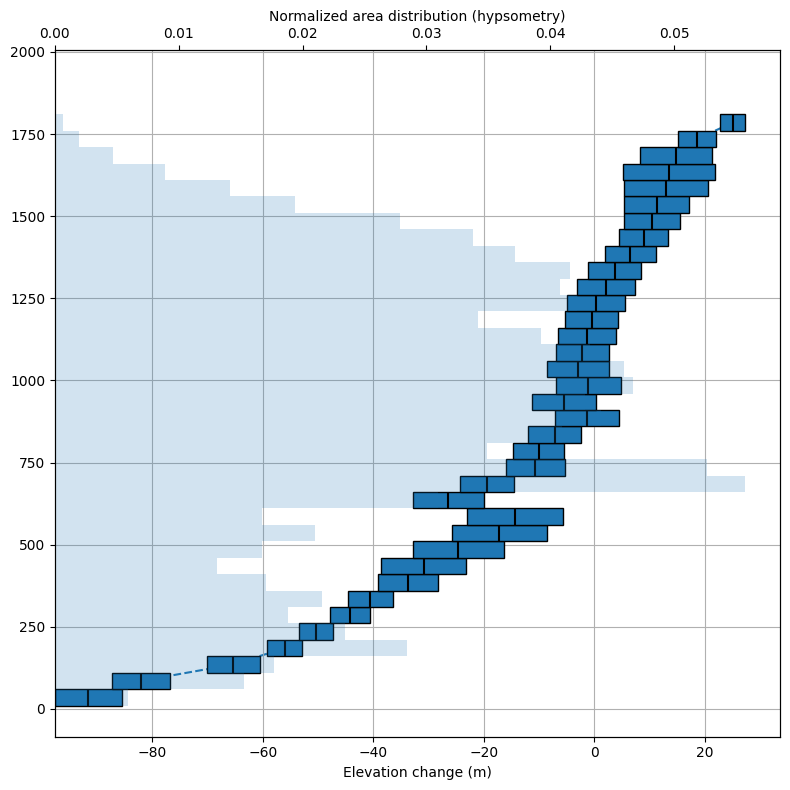

In [5]:
ddem_bins = xdem.volume.hypsometric_binning(ddem[mask], reference_dem[mask])
stds = xdem.volume.hypsometric_binning(ddem[mask], reference_dem[mask], aggregation_function=np.std)
bins_area = xdem.volume.calculate_hypsometry_area(ddem_bins, reference_dem[mask], pixel_size=ddem.res)

plt.figure(figsize=(8, 8))
plt.grid(zorder=0)

plt.plot(ddem_bins["value"], ddem_bins.index.mid, linestyle="--", zorder=1)

plt.barh(
    y=ddem_bins.index.mid,
    width=stds["value"],
    left=ddem_bins["value"] - stds["value"] / 2,
    height=(ddem_bins.index.left - ddem_bins.index.right) * 1,
    zorder=2,
    edgecolor="black",
)
for bin in ddem_bins.index:
    plt.vlines(ddem_bins.loc[bin, "value"], bin.left, bin.right, color="black", zorder=3)

plt.xlabel("Elevation change (m)")
plt.twiny()
plt.barh(
    y=ddem_bins.index.mid,
    width=ddem_bins["count"] / ddem_bins["count"].sum(),
    left=0,
    height=(ddem_bins.index.left - ddem_bins.index.right) * 1,
    zorder=2,
    alpha=0.2,
)
plt.xlabel("Normalized area distribution (hypsometry)")
plt.ylabel("Elevation (m a.s.l.)")
plt.tight_layout()
plt.show()

In [12]:
ddem_bins

,value,count
"(10.130157470703125, 60.130157470703125]",-91.648300,283333.0
"(60.130157470703125, 110.13015747070312]",-82.093369,731647.0
"(110.13015747070312, 160.13015747070312]",-65.340172,850270.0
"(160.13015747070312, 210.13015747070312]",-56.049911,1363548.0
"(210.13015747070312, 260.1301574707031]",-50.400841,1123482.0
"(260.1301574707031, 310.1301574707031]",-44.248871,903602.0
"(310.1301574707031, 360.1301574707031]",-40.528198,1035836.0
"(360.1301574707031, 410.1301574707031]",-33.812195,818424.0
"(410.1301574707031, 460.1301574707031]",-30.919403,629929.0
"(460.1301574707031, 510.1301574707031]",-24.641983,803810.0


In [14]:
average_value = ddem_bins['value'].mean()
average_value = average_value/63
print(f"The average value is: {average_value}")

The average value is: -0.22545594849493977


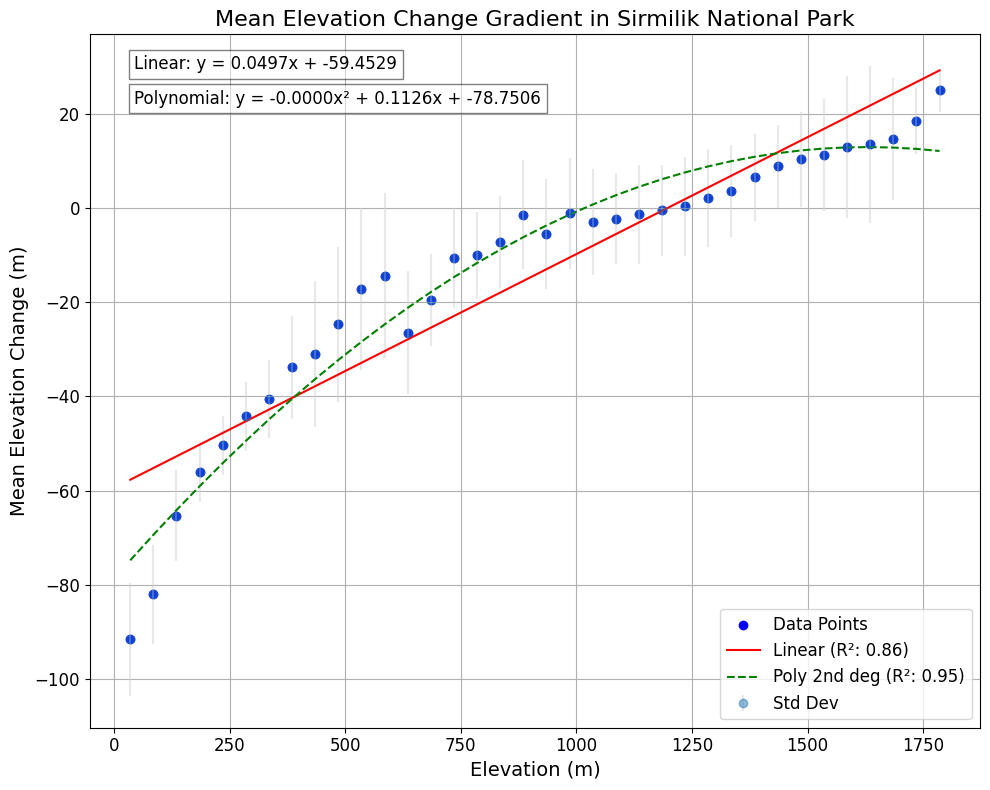

In [8]:
# Clean the data by removing rows with NaN values
ddem_bins_cleaned = ddem_bins.dropna()
stds_cleaned = stds.dropna()

# Align the indices of ddem_bins_cleaned and stds_cleaned
ddem_bins_cleaned, stds_cleaned = ddem_bins_cleaned.align(stds_cleaned, join='inner')

# Preparing the data
X = ddem_bins_cleaned.index.mid.values.reshape(-1, 1)
y = ddem_bins_cleaned['value'].values
y_err = stds_cleaned['value'].values 

# Fit Linear Regression
linear_model = LinearRegression()
linear_model.fit(X, y)

# Fit Polynomial Regression (Degree 2)
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X)
poly_model = LinearRegression()
poly_model.fit(X_poly, y)

# Calculate R^2 scores
r2_linear = r2_score(y, linear_model.predict(X))
r2_poly = r2_score(y, poly_model.predict(X_poly))

# Display equations
linear_eq = f"Linear: y = {linear_model.coef_[0]:.4f}x + {linear_model.intercept_:.4f}"
poly_coeffs = poly_model.coef_
poly_intercept = poly_model.intercept_
poly_eq = f"Polynomial: y = {poly_coeffs[2]:.4f}x² + {poly_coeffs[1]:.4f}x + {poly_intercept:.4f}"

# Predict values for visualization
y_linear = linear_model.predict(X)
y_poly = poly_model.predict(poly_features.transform(X))

# Plotting
plt.figure(figsize=(10, 8))
plt.errorbar(X, y, yerr=y_err, fmt='o', ecolor='lightgray', alpha=0.5, label='Std Dev')
plt.scatter(X, y, color='blue', label='Data Points')
plt.plot(X, y_linear, color='red', label=f'Linear (R²: {r2_linear:.2f})')
plt.plot(X, y_poly, color='green', linestyle='--', label=f'Poly 2nd deg (R²: {r2_poly:.2f})')

# Formatting plot text for the linear and polynomial regression equations
plt.text(0.05, 0.95, linear_eq, fontsize=12, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.text(0.05, 0.90, poly_eq, fontsize=12, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Formatting the plot
plt.title('Mean Elevation Change Gradient in Sirmilik National Park', fontsize=16)
plt.xlabel('Elevation (m)', fontsize=14)
plt.ylabel('Mean Elevation Change (m)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()



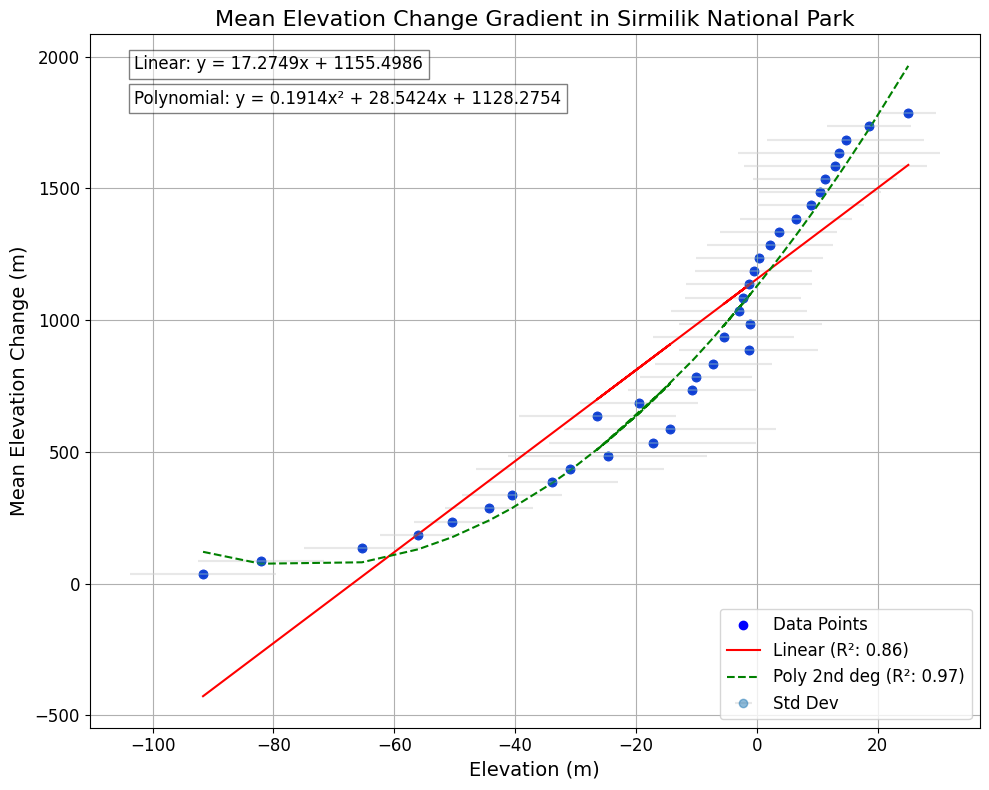

In [9]:
# Clean the data by removing rows with NaN values
ddem_bins_cleaned = ddem_bins.dropna()

# Assuming stds is a DataFrame aligned with ddem_bins and contains the standard deviations for mean elevation changes
stds_cleaned = stds.dropna()

# Preparing the data
y = ddem_bins_cleaned.index.mid.values.reshape(-1, 1)  # Elevation Bin Midpoints
X = ddem_bins_cleaned['value'].values.reshape(-1, 1)  # Mean Elevation Change
X_err = stds_cleaned['value'].values  # Standard Deviations

# Fit the linear regression model
linear_model.fit(X, y)
y_pred_linear = linear_model.predict(X)
r2_linear = r2_score(y, y_pred_linear)

# Fit Polynomial Regression (Degree 2)
X_poly = poly_features.fit_transform(X)
poly_model.fit(X_poly, y)
y_pred_poly = poly_model.predict(X_poly)
r2_poly = r2_score(y, y_pred_poly)

# Display equations
linear_eq = f"Linear: y = {linear_model.coef_[0][0]:.4f}x + {linear_model.intercept_[0]:.4f}"
poly_coeffs = poly_model.coef_
poly_intercept = poly_model.intercept_
poly_eq = f"Polynomial: y = {poly_coeffs[0][2]:.4f}x² + {poly_coeffs[0][1]:.4f}x + {poly_intercept[0]:.4f}"

# Predict values for visualization
y_linear = linear_model.predict(X)
y_poly = poly_model.predict(poly_features.transform(X))

# Plotting
plt.figure(figsize=(10, 8))

plt.errorbar(X.flatten(), y, xerr=X_err, fmt='o', ecolor='lightgray', alpha=0.5, label='Std Dev')
plt.scatter(X, y, color='blue', label='Data Points')
plt.plot(X, y_linear, color='red', label=f'Linear (R²: {r2_linear:.2f})')
plt.plot(X, y_poly, color='green', linestyle='--', label=f'Poly 2nd deg (R²: {r2_poly:.2f})')

# Formatting plot text for the linear and polynomial regression equations
plt.text(0.05, 0.95, linear_eq, fontsize=12, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.text(0.05, 0.90, poly_eq, fontsize=12, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Formatting the plot
plt.title('Mean Elevation Change Gradient in Sirmilik National Park', fontsize=16)
plt.xlabel('Elevation (m)', fontsize=14)
plt.ylabel('Mean Elevation Change (m)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


##### Regional interprotation

In [ ]:
# Get the regional hypsometric signal
signal = xdem.volume.get_regional_hypsometric_signal(
    ddem=ddem, 
    ref_dem=reference_dem, 
    glacier_index_map=mask
)

In [ ]:
# You can calculate the elevation change using regional hypsometric interpolation
ddem_filled = xdem.volume.norm_regional_hypsometric_interpolation(
    voided_ddem=ddem, 
    ref_dem=reference_dem, 
    glacier_index_map=mask, 
    regional_signal=signal
)

In [ ]:
ddem_filled = xdem.DEM.from_array(ddem_filled, transform=ddem.transform, crs=ddem.crs)

c:\Users\WilsonSIRL5-MCY-E113\miniconda3\envs\xdem\Lib\site-packages\geoutils\raster\raster.py:1935: UserWarning: Setting default nodata -99999 to mask non-finite values found in the array, as no nodata value was defined.
  warnings.warn(


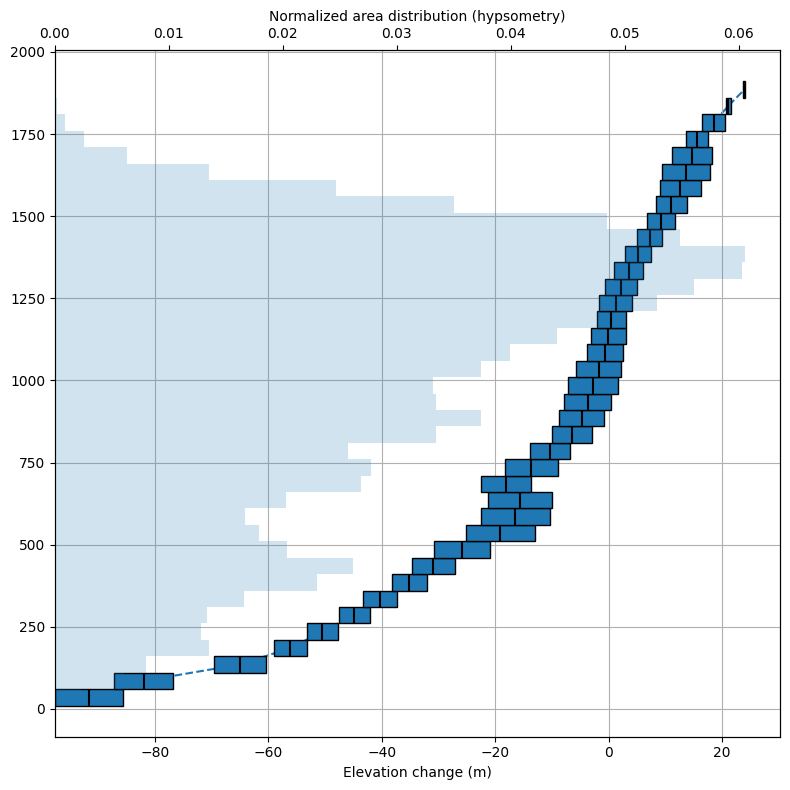

In [ ]:
ddem_bins_filled = xdem.volume.hypsometric_binning(ddem_filled[mask], reference_dem[mask])
stds_filled = xdem.volume.hypsometric_binning(ddem_filled[mask], reference_dem[mask], aggregation_function=np.std)
bins_area_filled = xdem.volume.calculate_hypsometry_area(ddem_bins_filled, reference_dem[mask], pixel_size=ddem.res)

plt.figure(figsize=(8, 8))
plt.grid(zorder=0)

plt.plot(ddem_bins_filled["value"], ddem_bins_filled.index.mid, linestyle="--", zorder=1)

plt.barh(
    y=ddem_bins_filled.index.mid,
    width=stds_filled["value"],
    left=ddem_bins_filled["value"] - stds_filled["value"] / 2,
    height=(ddem_bins_filled.index.left - ddem_bins_filled.index.right) * 1,
    zorder=2,
    edgecolor="black",
)
for bin in ddem_bins_filled.index:
    plt.vlines(ddem_bins_filled.loc[bin, "value"], bin.left, bin.right, color="black", zorder=3)

plt.xlabel("Elevation change (m)")
plt.twiny()
plt.barh(
    y=ddem_bins_filled.index.mid,
    width=ddem_bins_filled["count"] / ddem_bins_filled["count"].sum(),
    left=0,
    height=(ddem_bins_filled.index.left - ddem_bins_filled.index.right) * 1,
    zorder=2,
    alpha=0.2,
)
plt.xlabel("Normalized area distribution (hypsometry)")
plt.ylabel("Elevation (m a.s.l.)")
plt.tight_layout()
plt.show()

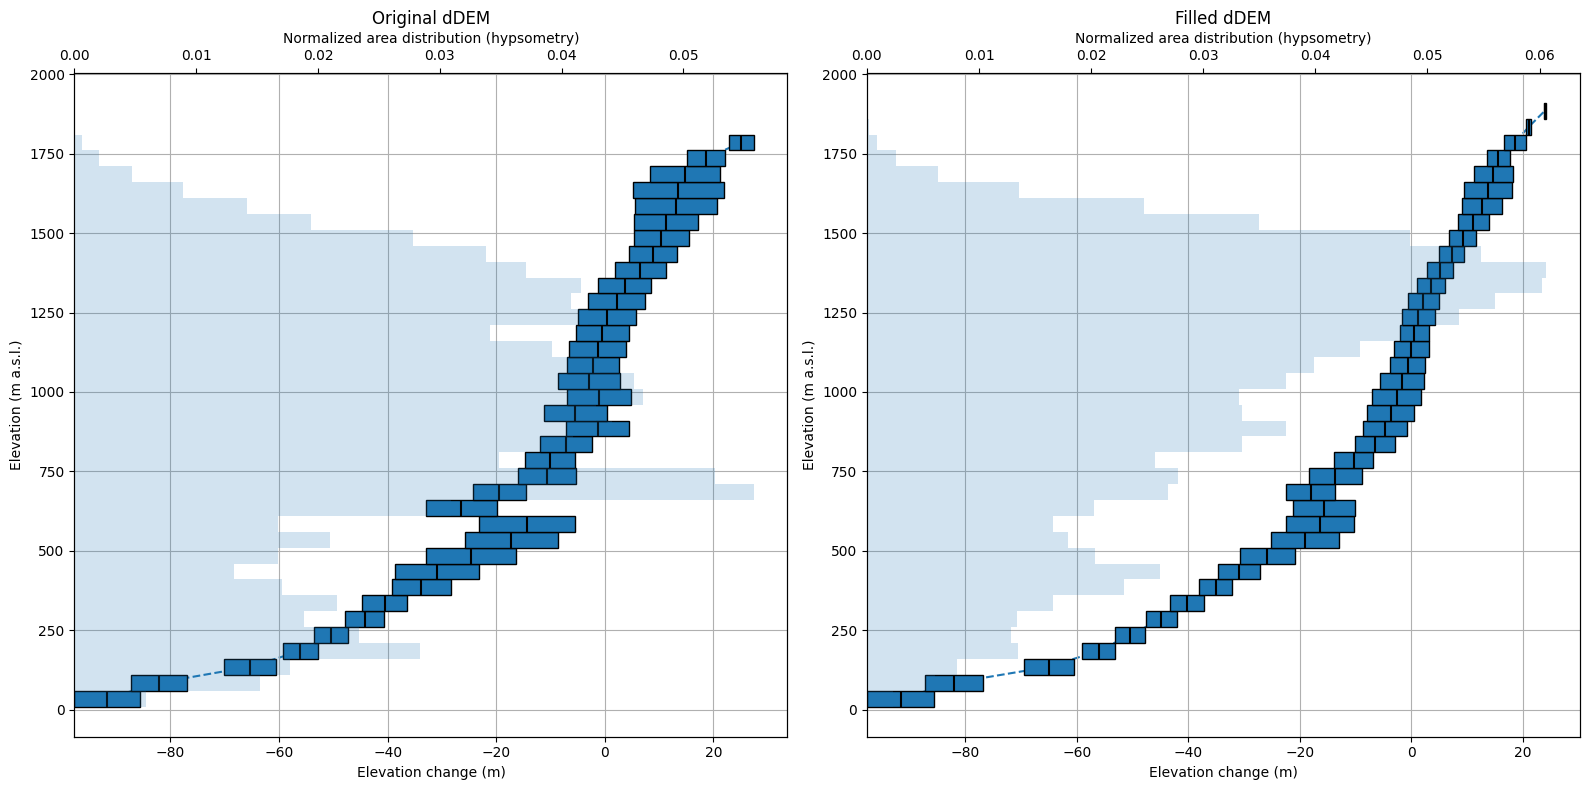

In [ ]:
# Plotting both graphs side by side with subtitles
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# First plot
ax1.grid(zorder=0)
ax1.plot(ddem_bins["value"], ddem_bins.index.mid, linestyle="--", zorder=1)
ax1.barh(
    y=ddem_bins.index.mid,
    width=stds["value"],
    left=ddem_bins["value"] - stds["value"] / 2,
    height=(ddem_bins.index.left - ddem_bins.index.right) * 1,
    zorder=2,
    edgecolor="black",
)
for bin in ddem_bins.index:
    ax1.vlines(ddem_bins.loc[bin, "value"], bin.left, bin.right, color="black", zorder=3)
ax1.set_xlabel("Elevation change (m)")
ax1.set_ylabel("Elevation (m a.s.l.)")
ax1.set_title("Original dDEM")

ax1_twiny = ax1.twiny()
ax1_twiny.barh(
    y=ddem_bins.index.mid,
    width=ddem_bins["count"] / ddem_bins["count"].sum(),
    left=0,
    height=(ddem_bins.index.left - ddem_bins.index.right) * 1,
    zorder=2,
    alpha=0.2,
)
ax1_twiny.set_xlabel("Normalized area distribution (hypsometry)")

# Second plot
ax2.grid(zorder=0)
ax2.plot(ddem_bins_filled["value"], ddem_bins_filled.index.mid, linestyle="--", zorder=1)
ax2.barh(
    y=ddem_bins_filled.index.mid,
    width=stds_filled["value"],
    left=ddem_bins_filled["value"] - stds_filled["value"] / 2,
    height=(ddem_bins_filled.index.left - ddem_bins_filled.index.right) * 1,
    zorder=2,
    edgecolor="black",
)
for bin in ddem_bins_filled.index:
    ax2.vlines(ddem_bins_filled.loc[bin, "value"], bin.left, bin.right, color="black", zorder=3)
ax2.set_xlabel("Elevation change (m)")
ax2.set_ylabel("Elevation (m a.s.l.)")
ax2.set_title("Filled dDEM")

ax2_twiny = ax2.twiny()
ax2_twiny.barh(
    y=ddem_bins_filled.index.mid,
    width=ddem_bins_filled["count"] / ddem_bins_filled["count"].sum(),
    left=0,
    height=(ddem_bins_filled.index.left - ddem_bins_filled.index.right) * 1,
    zorder=2,
    alpha=0.2,
)
ax2_twiny.set_xlabel("Normalized area distribution (hypsometry)")

plt.tight_layout()
plt.show()

In [ ]:
ddem_filled.save("D:\BICdata\SNPDEMcoreg_ddempost_wregional.tif")